# FYP Project 2 - Melanoma Detection

##### Group G: Christina Aftzidis, Germán Buttiero, Hubert Wójcik, Laurids Holme Pedersen and Paula Menshikoff

### How to run this notebook

The file paths are stored in a separate Config file. Change the file paths in the Config file before running the notebook. 
The notebook is written in a way that automatically saves the figures to a separate folder once you run it. If you do not want the figures to be saved, set savefigs to False in the first cell after the imports.

### Research Question
*Is it possible to predict melanoma from an image of a skin lesion?* \
*Do our classifier's predictions differ for women and men?*

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import Config
import os, sys

#imports for data visualization
import seaborn as sns
import ptitprince as pt 

#imports for image processing
import skimage.io as sk
from skimage import morphology
from skimage.color import rgb2gray
from statsmodels.robust import mad
from PIL import Image

#imports for classifier 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler # normalise features
from imblearn.over_sampling import RandomOverSampler
import pickle

In [2]:
#basis for saving the figures into a separate folder
savefigs = True

if savefigs:
    if not os.path.isdir('../figs'):
        os.makedirs('../figs')

### Dataframes

In [3]:
df = pd.read_csv(Config.features_path) #data frame for 150 images

mel_df = pd.read_csv("../data/example_ground_truth.csv")
df['melanoma'] = mel_df['melanoma']

## Task 0 - exploring the data 
Investigating the **data provided by our teacher** - looking for missing values in .csv files as well as getting familiar with the data using the `df.describe()` function.

In [4]:
#getting the shape of df
print(f'shape of the df with 150 images: {df.shape}')

#looking for missing data
print(f'Are there any missing values in the dataset? {df.isna().any().any()}')

#getting the diagnosis types
print('')
print(f'The diagnosis types: {mel_df.columns[1:]}')

shape of the df with 150 images: (150, 4)
Are there any missing values in the dataset? False

The diagnosis types: Index(['melanoma', 'seborrheic_keratosis'], dtype='object')


In [5]:
df.describe()

,area,perimeter,melanoma
count,1.500000e+02,150.00000,150.00000
mean,3.114134e+06,5570.36000,0.20000
std,5.897570e+06,5294.59662,0.40134
min,3.294400e+04,642.00000,0.00000
25%,2.329922e+05,2014.50000,0.00000
50%,6.223165e+05,3324.50000,0.00000
75%,2.054852e+06,7137.50000,0.00000
max,2.770686e+07,25900.00000,1.00000


## Task 1 - measuring the features ourselves

We manually classified 50 pictures of skin lesions by using the ABC features (Asymmetry, Border, Color). Our final rankings are in one csv file called ID_rating.csv. There are also separate csv files for the individual ABC rankings.

In [6]:
#load in our guesses from the csv file
guesses = pd.read_csv(Config.id_rating_path)

In [7]:
#dropping columns that are not relevant or contain NaN values  
todrop = ["image_id", "Chris", "Germán", "Hubert", "Laurids", "Pau", "All Agree", "Guessed the same"]
guesses = guesses.drop(columns=todrop)

In [8]:
#convert all values to integers, drop row 50 because it was a summary and not part of the data
guesses = guesses.astype(dtype="int")
guesses = guesses.drop(50, axis=0)

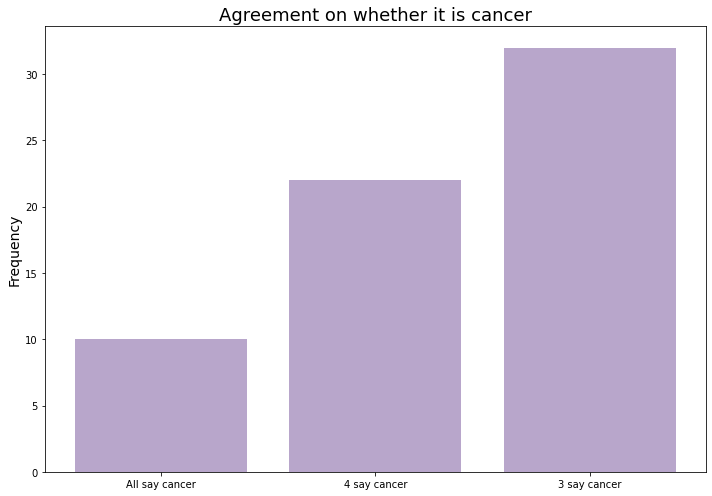

In [9]:
#plot our agreement on whether it is cancer in form of a barplot
dx = ["All say cancer", "4 say cancer", "3 say cancer"]
dy = [sum(guesses["All say cancer"]),sum(guesses["4 say cancer"]) , sum(guesses["3 say cancer"])]

f, ax = plt.subplots(figsize=(10,7))
ax1 = plt.bar(x=dx,data=guesses, height=dy, color="#b8a6cb")

ax.set_ylabel("Frequency", fontsize=14)
plt.title("Agreement on whether it is cancer", fontsize=18)
plt.tight_layout()

if savefigs:
    plt.savefig('../figs/figure0101.png', bbox_inches='tight')


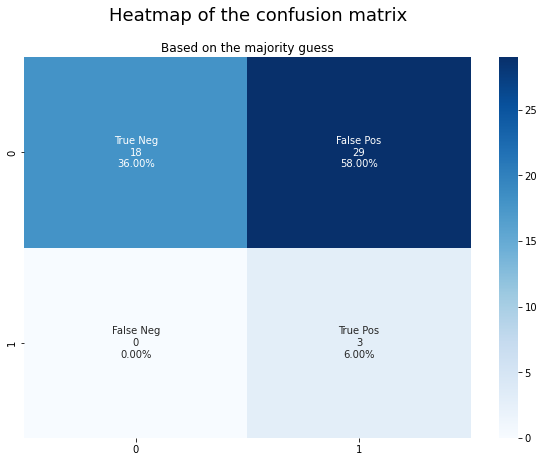

In [10]:
#creating a confusion matrix from our guesses
cf = confusion_matrix(guesses["Melanoma"], guesses["3 say cancer"])

#creating labels to add to the heatmap
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#creating the heatmap and adding titels
f, ax = plt.subplots(figsize=(10,7))
sns.heatmap(cf, annot=labels, fmt="", cmap='Blues')

plt.suptitle("Heatmap of the confusion matrix", fontsize=18, x=0.45)
plt.title("Based on the majority guess", fontsize=12)

if savefigs:
    plt.savefig("../figs/figure0102.png", bbox_inches="tight")

## Task 2 - Creating our feature measurements

### Picture Class
This class contains all the feature functions that we apply for each image as well as a function that measures the area and perimeter of an image.

#### Asymmetry:
The asymmetry is given as a value between 0 and 1. We get this value by folding the segmentation mask multiple times and rotating in between, calculating the ratio of pixels that are equal after folding, and taking the mean out of all the different rotations. 

#### Compactness:
The compactness is calculated using the area and perimeter of the skin lesion. The formula for the compactness is $\frac{4 \cdot \pi \cdot A}{p^2}$ where A is the area and p is the perimeter. The optimal compactness is 1 and the closer to 1 the values are, the more circular the lesion is.

#### Color variability:
The color variability is calculated using the variance of the rgb values in the lesion and then taking the average. 

In [11]:
class Picture:
    def __init__(self, img, img_bw):
        self.img = img #main image
        self.img_bw = self._cut_image(img_bw) #the image in black & white version

    #ASYMMETRY
    def _cut_image(self, picture):
        ''' Makes the number of pixels in width and height an even number  '''
        picture = picture.crop(picture.getbbox())
        width, height = picture.size
        image = np.array(picture)
        
        if width %2 != 0:
            image = np.delete(image, -1, 1)

        if height %2 != 0:
            image = np.delete(image, -1, 0)

        image = Image.fromarray(image)

        return image

    def _asymmetry(self, rot_img):
        '''Gets the asymmetry between the left and right part of a given binary mask '''
        width, height = rot_img.size #mask should be quadratic and therefore have equal dimension
        size = width * height

        #check for uneven number of pixels (should not happen but just as a precaution)
        if width %2 != 0:
            raise TypeError('Uneven number of pixel and cannot be symmetric')
        
        #cut in half and fold
        left = rot_img.crop((0, 0, (width/2), height)) #left part of picture (left, top, right, bottom)
        right = rot_img.crop(((width/2), 0, width, height)) #right part of picture
        right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare

        #get the binary difference between left an right
        symmetry = np.where(np.array(left) != np.array(right), 1, 0)

        return np.sum(symmetry) / (size/2) #the percentage of asymmetry 
    
    def get_asymmetry(self):
        '''Returns the asymmetry for a given mask by folding it in half from multiple angles'''
        return round(np.mean([self._asymmetry(self.img_bw), self._asymmetry(self.img_bw.rotate(30, expand= True)),self._asymmetry(self.img_bw.rotate(60, expand= True)),self._asymmetry(self.img_bw.rotate(90, expand= True))]),2)

    #BORDER
    def measure_area_perimeter(self): 
        '''Measures the area and perimeter of a mask image'''
        #area: the sum of all white pixels in the mask image
        mask = np.where(np.array(self.img_bw)==255, 1, 0)
        area = np.sum(mask)

        #perimeter: first find which pixels belong to the perimeter.
        struct_el = morphology.disk(1)
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        image_perimeter = mask - mask_eroded

        #now we have the perimeter image, the sum of all white pixels in it
        perimeter = np.sum(image_perimeter)

        return area, perimeter

    def get_compactness(self):
        '''Computes and returns the compactness of a figure'''
        area, perimeter = self.measure_area_perimeter()
        return round(4*np.pi*area / perimeter ** 2, 4)


    #COLOR
    def get_color_variability(self):
        '''Checks the variability of a color - returns the mean of the variance of each color dimension (rgb)'''
        self.img[self.img_bw==0] = 0
        
        #we then calculate the variance of each dimension 
        r, g, b = self.img[:,:,0], self.img[:,:,1], self.img[:,:,2]
        var_r= np.var(r[np.where(r != 0)])
        var_g= np.var(g[np.where(g != 0)])
        var_b= np.var(b[np.where(b != 0)])
        var_result= [var_r,var_g,var_b]

        #calculating the mean
        return np.mean(var_result)
    

### Visualizing the feature functions
Creating plots of each feature function in order to explore our measurements.

#### Asymmetry plots

In [12]:
#general code needed for all the plots
plot_data = pd.read_csv(Config.sex_features_path)
colors = ["#8ba888","#d0312d" ]
dx = "Melanoma"; sigma = .2; ort="h"

font = {'size'   : 13}

plt.rc('font', **font)

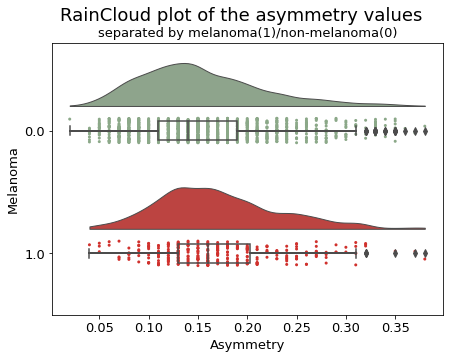

In [13]:
#plotting the asymmetry values
dy= "Asymmetry"
f, ax = plt.subplots(figsize = (7,5))

ax = pt.RainCloud(data=plot_data, x=dx, y=dy, 
palette=colors, bw=sigma, width_viol=.7, ax=ax, orient=ort)

plt.suptitle("RainCloud plot of the asymmetry values", fontsize=18);
plt.title("separated by melanoma(1)/non-melanoma(0)", fontsize=13);

if savefigs:
    plt.savefig('../figs/figure0201.png', bbox_inches='tight')

#### Border (compactness) plots

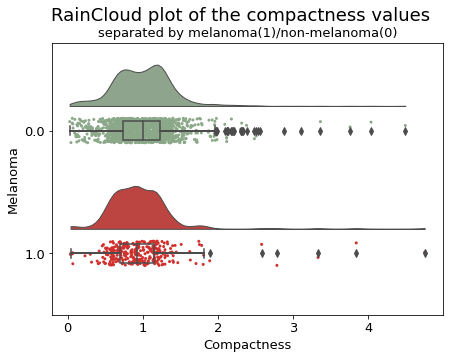

In [14]:
#plotting the compactness values
dy= "Compactness"
f, ax = plt.subplots(figsize = (7,5))

ax = pt.RainCloud(data=plot_data, x=dx, y=dy, 
palette=colors, bw=sigma, width_viol=.7, ax=ax, orient=ort)

plt.suptitle("RainCloud plot of the compactness values", fontsize=18);
plt.title("separated by melanoma(1)/non-melanoma(0)", fontsize=13);

if savefigs:
    plt.savefig('../figs/figure0202.png', bbox_inches='tight')

#### Color variability plots

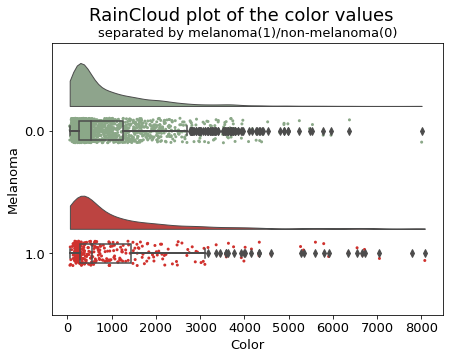

In [15]:
#plotting the color values
dy= "Color"
f, ax = plt.subplots(figsize = (7,5))

ax = pt.RainCloud(data=plot_data, x=dx, y=dy, 
palette=colors, bw=sigma, width_viol=.7, ax=ax, orient=ort)

plt.suptitle("RainCloud plot of the color values", fontsize=18);
plt.title("separated by melanoma(1)/non-melanoma(0)", fontsize=13);

if savefigs:
    plt.savefig('../figs/figure0203.png', bbox_inches='tight')

## Task 3 - predicting the diagnosis

#### get_row()
`get_row()` returns a dataframe with one row with data about a given picture.

In [16]:
def get_row(pict, pic):  
    assym = pict.get_asymmetry()
    comp = pict.get_compactness()
    color = pict.get_color_variability()

    melanoma = sex_df[sex_df['ISIC'] == pic]['Melanoma'].iloc[0]

    return pd.DataFrame([[pic, assym, comp, color, melanoma]], 
                        columns=['ISIC', 'Asymmetry', 'Compactness', 'Color', 'Melanoma'])

#### create_df()
`create_df()` takes a set of image IDs and returns a pandas dataframe with the calculated features for each image 

In [17]:
def create_df(img_names):
    features_df = pd.DataFrame(columns=['ISIC', 'Asymmetry', 'Compactness', 'Color', 'Melanoma'])
    for pic in img_names:
        img_bw = Image.open(Config.mask_path + os.sep + pic + '_segmentation.png') # open mask image

        img = plt.imread(Config.images_path + os.sep + pic + '.jpg') # open image
        pict = Picture(img = img, img_bw = img_bw)
        tempdf = get_row(pict, pic)
        features_df = pd.concat([features_df, tempdf], axis=0, ignore_index=True)

    return features_df

In [18]:
def normalise_df(X_dev, X_test):
    f=["Asymmetry","Compactness", "Color"]

    scaler = StandardScaler().fit(X_dev) # (x - mu) / std
    X_dev = pd.DataFrame(scaler.transform(X_dev), columns=f)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=f)

    return X_dev, X_test

#### Classifier training and evaluation

In [19]:
def tree_classifier(X_train, X_val, y_train, y_val, to_pickle=False):
    tree = DecisionTreeClassifier()
    treetrained = tree.fit(X_train, y_train)


    tree_proba_prediction = tree.predict_proba(X_val)
    tree_prediction = treetrained.predict(X_val)

    fpr, tpr, threshold = roc_curve(y_val, tree_proba_prediction[:, 1])
    roc_auc = auc(fpr, tpr)

    if to_pickle:
        with open('treeclassifier.pickle', 'wb') as outfile:
            pickle.dump(treetrained, outfile)

    return fpr, tpr, roc_auc, tree_proba_prediction, tree_prediction, treetrained

In [20]:
# Reporting classifier tests
def test_classifier(X_test, y_test, treetrained):

    tree_prediction = treetrained.predict(X_test)

    acc_test = accuracy_score(y_test, tree_prediction)
    auc_test = roc_auc_score(y_test, tree_prediction)

    print(f'The accuracy score for the test set is {acc_test}')
    print(f'The roc auc score for the test set is {auc_test}')


#### Plotting roc curve and confusion matrix

In [21]:
def plot_roc_curve(fpr, tpr, roc_auc):
    ''' function that plots an roc curve '''
    f, ax = plt.subplots(figsize=(10,7))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')

    #adding a legend
    plt.legend(loc = 'lower right')

    #setting x and y limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    #adding labels and titles
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of classifier', fontsize=10)
    plt.suptitle('Receiver Operating Characteristic', fontsize=18)

    if savefigs:
        plt.savefig('../figs/figure0301.png', bbox_inches='tight')

In [22]:
def plot_confusion_matrix(X_val, y_val,treetrained,tree_prediction):
    ''' function that plots a confusion matrix for our ml model '''
    
    f, ax = plt.subplots(figsize=(10,7))
    roc = roc_auc_score(y_val, tree_prediction)
    cf_matrix = confusion_matrix(y_val, tree_prediction)
    ax1 = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                fmt='.2%', cmap='Blues')

    #set title and labels of the axes
    ax.set_title('Confusion Matrix of the actual values and our predicted values');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    # Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    if savefigs:
        plt.savefig('../figs/figure0302.png', bbox_inches='tight')

### Main()
The `main()` functon iterates over each image, creates an instance of the `Picture` class, and adds a row to a dataframe with all functions using the `get_row()` function. Ultimately, it returns the `train_evaluate_classifiers()` function with the dataframe mentioned above as the attribute.

In [23]:
#merging
female_df = pd.read_csv(Config.female_features_path)
male_df = pd.read_csv(Config.male_features_path)

sex_df = pd.concat([female_df, male_df], axis=0)
#all_df.to_csv('../features/sex_features.csv')

In [24]:
def main(df, to_plot=True, to_return=False):
    image_names = [ID for ID in sex_df['ISIC']] 
    #features_df = create_df(image_names)
    features_df = df

    X = features_df[["Asymmetry","Compactness", "Color"]]
    y = features_df["Melanoma"]

    oversample = RandomOverSampler(sampling_strategy=0.5)
    X_over, y_over = oversample.fit_resample(X, y)
    
    X_dev, X_test, y_dev, y_test = train_test_split(X_over, y_over, stratify=y_over, random_state=0)

    X_dev, X_test= normalise_df(X_dev, X_test)

    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify=y_dev)
    
    fpr, tpr, roc_auc, tree_proba_prediction, tree_prediction, treetrained = tree_classifier(X_train, X_val, y_train, y_val)


    if to_plot:
        test_classifier(X_test, y_test, treetrained)
        plot_roc_curve(fpr, tpr, roc_auc)
        plot_confusion_matrix(X_val, y_val, treetrained, tree_prediction) 

    if to_return:
        return tree_prediction, y_val

The accuracy score for the test set is 0.7560521415270018
The roc auc score for the test set is 0.755586592178771


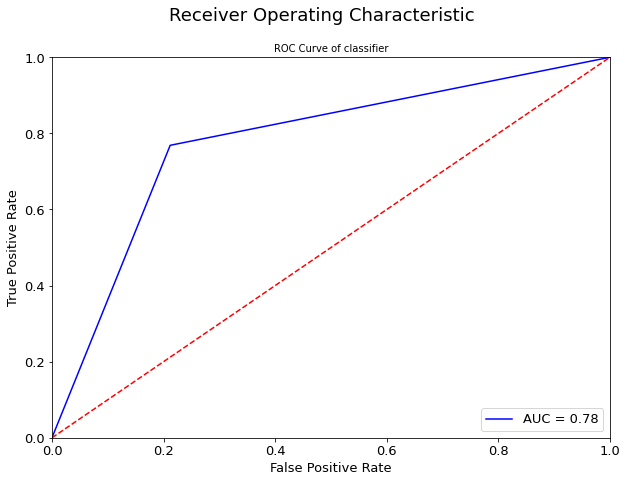

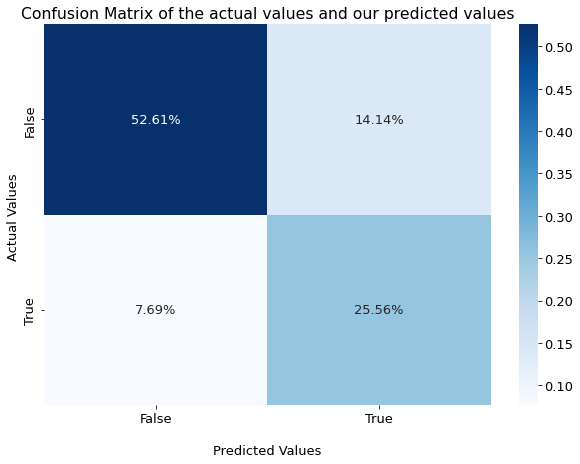

In [25]:
main(sex_df)

## Task 4 - Does our algorithm perform better among women? 

For this task we want to test whether our classifier works better for women than for men. 

In [26]:
female_acc = []
female_roc = []
female_bal = []
male_acc = []
male_roc = []
male_bal = []
n = 100


for _ in range(n):
    #predicting for women
    prediction, y_val = main(female_df, to_plot=False, to_return=True)
    female_acc.append(accuracy_score(y_val, prediction))
    female_roc.append(roc_auc_score(y_val, prediction))
    female_bal.append(balanced_accuracy_score(y_val,prediction))

for _ in range(n):
    #predicting for men
    prediction, y_val = main(male_df, to_plot=False, to_return=True)
    male_acc.append(accuracy_score(y_val, prediction))
    male_roc.append(roc_auc_score(y_val, prediction))
    male_bal.append(balanced_accuracy_score(y_val,prediction))


print(f'Female mean scores; \
        acc: {round(np.mean(female_acc),3)} \
        roc: {round(np.mean(female_roc),3)} \
        bal: {round(np.mean(female_bal),3)}')

print('===============================')

print(f'Male mean scores; \
        acc: {round(np.mean(male_acc),3)} \
        roc: {round(np.mean(male_roc),3)} \
        bal: {round(np.mean(male_bal),3)}')




Female mean scores;         acc: 0.825         roc: 0.835         bal: 0.835
Male mean scores;         acc: 0.718         roc: 0.705         bal: 0.705


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=932aa97b-f6d2-4889-8f04-d6166675cc2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>